Tests reproducibilty of stochastic partial differential equation results in 10.1016/j.jcp.2019.07.048.

In [1]:
import json
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import os
from tqdm.auto import tqdm, trange
from typing import Optional

import sde

store_data = True
load_data = False

sample_size = 1000
tested_sample_sizes = [100, 500, 1000, 5000, 10000]
confidence = 0.95

fig_kwargs = dict(
    layout='compressed',
    figsize=(8.0, 3.0)
)
plot_all_kwargs = dict(
    color='gray',
    alpha=0.1
)

results_dir = os.path.join('results', 'zhang_2019')

In [2]:
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)


def solve_diffusion_1d(force, x, bc_left, bc_right):
    # Number of grid points
    n = len(x)
    
    # Grid spacing
    dx = x[1] - x[0]
    
    # Initialize the coefficient matrix and right-hand side vector
    mat = np.zeros((n, n))
    b = np.array(force, dtype=float)
    
    # Apply boundary conditions
    mat[0, 0] = 1.0
    b[0] = bc_left
    mat[-1, -1] = 1.0
    b[-1] = bc_right
    
    # Fill the coefficient matrix and right-hand side vector for interior points
    dx2 = dx * dx
    for i in range(1, n-1):
        mat[i, i-1] = 1.0 / dx2
        mat[i, i] = -2.0 / dx2
        mat[i, i+1] = 1.0 / dx2
    
    # Solve and return the linear system
    return np.linalg.solve(mat, b)

In [3]:
class SPDEProblem:

    def __init__(self,
                 sample_size: int,
                 length_scale = 1.0,
                 sigma_f = 1.0,
                 a = 10.0,
                 w = np.pi,
                 num_points=100):
        
        self.sample_size = sample_size
        self.length_scale = length_scale
        self.sigma_f = sigma_f
        self.a = a
        self.w = w
        self.num_points = num_points

        self.results: Optional[sde.SDEResultSample] = None

    def copy(self):
        result = SPDEProblem(self.sample_size,
                             self.length_scale,
                             self.sigma_f,
                             self.a,
                             self.w,
                             self.num_points)
        if self.results is not None:
            result.results = self.results.copy()
        return result

    def generate_metadata(self, *args, **kwargs) -> sde.sim_lib.Metadata:
        if self.results is not None:
            self.run()
        return self.results.generate_metadata(*args, **kwargs)

    @property
    def x(self):
        return np.linspace(-1.0, 1.0, self.num_points).reshape(-1, 1)

    def covariance(self, x1, x2):
        """Squared Exponential Covariance Function"""
        sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.sigma_f**2 * np.exp(-sqdist / self.length_scale**2)

    def mean_function(self, x):
        return np.sin(x * self.w) * self.a

    def force_function(self, x):
        return np.random.multivariate_normal(self.mean_function(x).ravel(), self.covariance(x, x), size=self.sample_size)

    def run(self):
        self.results = sde.SDEResultSample(['u'], self.sample_size, self.num_points)
        x = self.x
        self.results.time = x.flatten()
        forces = self.force_function(x)
        for i in range(self.sample_size):
            self.results.data[i, 0, :] = solve_diffusion_1d(forces[i, :], x, 0.0, 0.0).flatten()
        return forces, self.results

    def to_json(self):
        result = dict(
            sample_size=self.sample_size,
            length_scale=self.length_scale,
            sigma_f=self.sigma_f,
            a=self.a,
            w=self.w,
            num_points=self.num_points
        )
        if self.results is not None:
            result['results'] = self.results.to_json()
        return result

    @classmethod
    def from_json(cls, _data: dict):
        result = cls(
            sample_size=int(_data['sample_size']),
            length_scale=float(_data['length_scale']),
            sigma_f=float(_data['sigma_f']),
            a=float(_data['a']),
            w=float(_data['w']),
            num_points=int(_data['num_points'])
        )
        if 'results' in _data:
            result.results = sde.SDEResultSample.from_json(_data['results'])
        return result

In [4]:
problem = SPDEProblem(sample_size=sample_size)
problem_forces = problem.run()[0]

/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i-1] = 1.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i] = -2.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i+1] = 1.0 / dx2


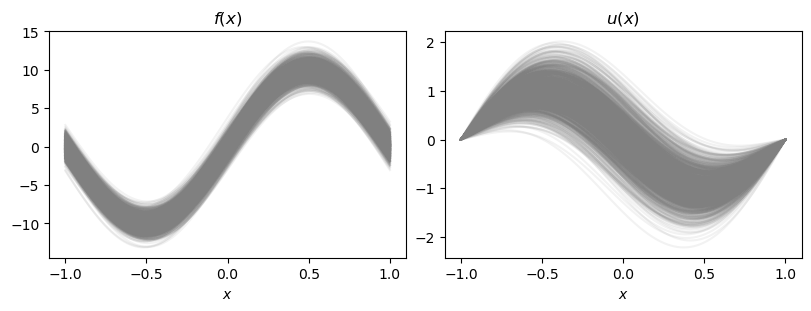

In [5]:
fig, axs = plt.subplots(1, 2, **fig_kwargs)
axs[0].plot(problem.x, problem_forces.T, **plot_all_kwargs)
axs[0].set_xlabel('$x$')
axs[0].set_title('$f(x)$')
problem.results.plot(fig_axs=(fig, [axs[1]]), plot_all_kwargs=plot_all_kwargs)
axs[1].set_xlabel('$x$')
_ = axs[1].set_title('$u(x)$')

In [6]:
prefix = 'results'
tested_problems = {}

if load_data:
    for fp in os.listdir(results_dir):
        if fp.startswith(prefix) and fp.endswith('.json'):
            with open(os.path.join(results_dir, fp), 'r') as f:
                data = json.load(f)
            p = SPDEProblem.from_json(data['problem'])
            tested_problems[p.sample_size] = p

    tested_sample_sizes = list(tested_problems.keys())
    tested_sample_sizes.sort()

else:
    for i, sz in tqdm(enumerate(tested_sample_sizes), total=len(tested_sample_sizes), desc='Evaluating problems'):
        p = SPDEProblem(sample_size=sz)
        p.run()
        tested_problems[sz] = p

        if store_data:
            with open(os.path.join(results_dir, f'{prefix}_{i}.json'), 'w') as f:
                json.dump(dict(problem=p.to_json()), f, indent=4)

Evaluating problems:   0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i-1] = 1.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i] = -2.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i+1] = 1.0 / dx2


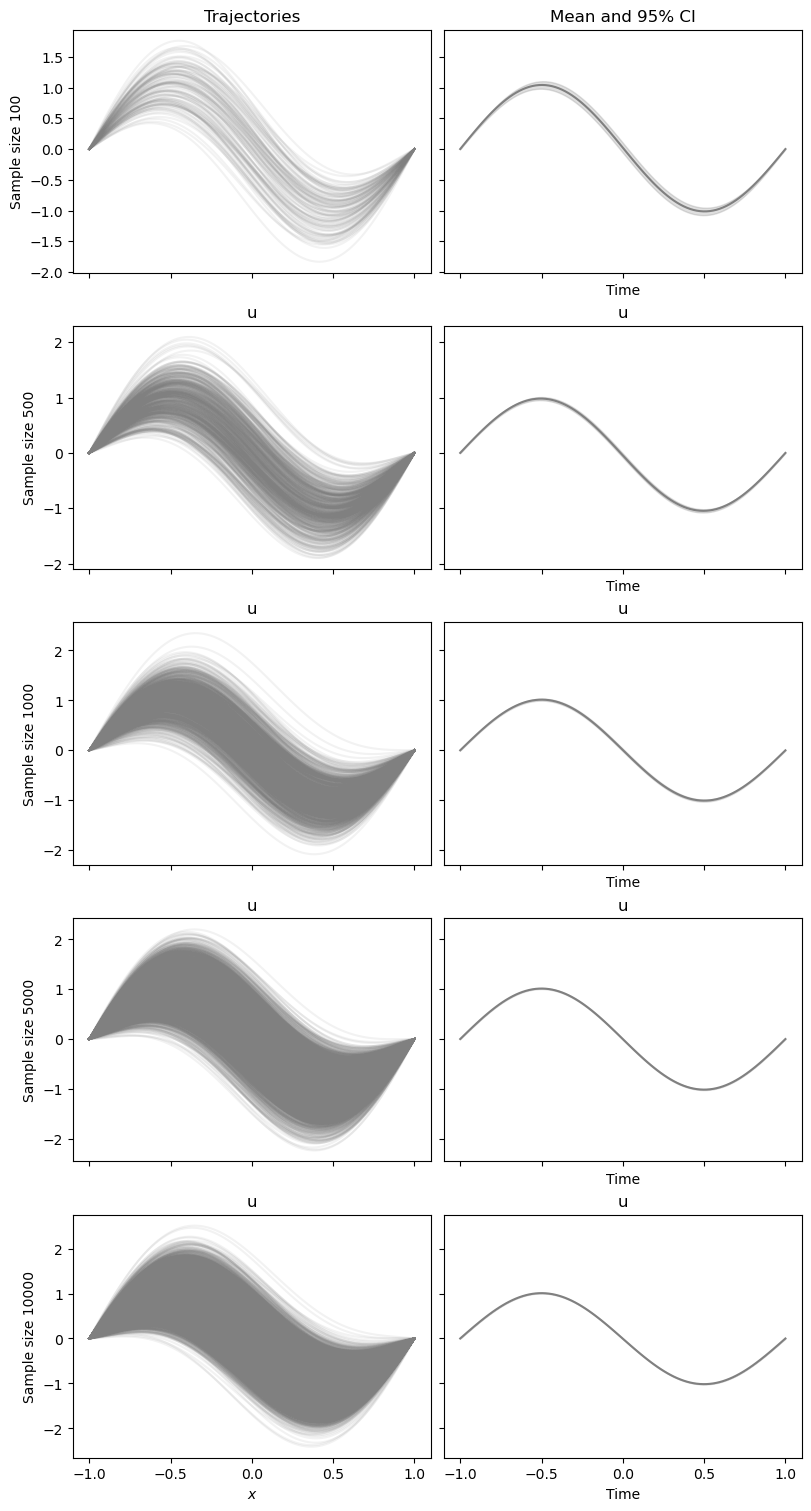

In [7]:
fig_axs = plt.subplots(len(tested_problems), 2, layout='compressed', sharex=True, sharey='row', 
                       figsize=(fig_kwargs['figsize'][0], fig_kwargs['figsize'][1] * len(tested_sample_sizes)))
for i, sz in enumerate(tested_sample_sizes):
    p: SPDEProblem = tested_problems[sz]
    p.results.plot(fig_axs=(fig_axs[0], [fig_axs[1][i][0]]), plot_all_kwargs=plot_all_kwargs)
    fig_axs[1][i][0].set_xlabel('')

    p.results.plot_ci(confidence, fig_axs=(fig_axs[0], [fig_axs[1][i][1]]), plot_all_kwargs=dict(color='gray', alpha=0.25))
    p.results.plot_mean(fig_axs=(fig_axs[0], [fig_axs[1][i][1]]), plot_all_kwargs=dict(color='gray'))

    fig_axs[1][i][0].set_ylabel(f'Sample size {p.sample_size}')

fig_axs[1][0][0].set_title('Trajectories')
fig_axs[1][0][1].set_title(f'Mean and {int(confidence * 100)}% CI')
_ = fig_axs[1][-1][0].set_xlabel('$x$')

Evaluating reproducibility:   0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i-1] = 1.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i] = -2.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i+1] = 1.0 / dx2


EFECT Error (mean +- st. dev)
	Sample size 100: 0.5336464967731162 +- 0.050532625054717215
	Sample size 500: 0.24171996994856038 +- 0.023142657605106896
	Sample size 1000: 0.17057552981211793 +- 0.016577396495861506
	Sample size 5000: 0.07580602687482683 +- 0.006864195123948167
	Sample size 10000: 0.05330761062632229 +- 0.004703766150265461


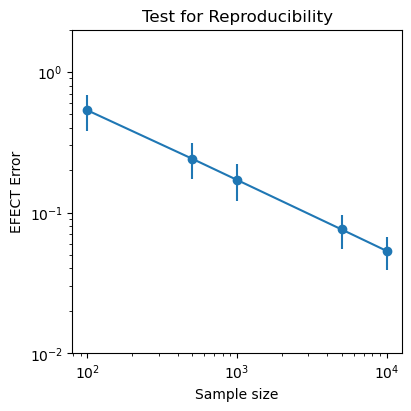

In [8]:
ssr_metadata = {}

if load_data:
    for fp in os.listdir(results_dir):
        if fp.startswith(prefix) and fp.endswith('.json'):
            with open(os.path.join(results_dir, fp), 'r') as f:
                data = json.load(f)
            md = sde.sim_lib.Metadata.from_json(data['metadata'])
            ssr_metadata[md.sample_size * 2] = md

else:
    for i, sz in tqdm(enumerate(tested_sample_sizes), total=len(tested_sample_sizes), desc='Evaluating reproducibility'):
        md = tested_problems[sz].generate_metadata(err_thresh=1E-3)
        ssr_metadata[sz] = md

        if store_data:
            fp = os.path.join(results_dir, f'{prefix}_{i}.json')
            with open(fp, 'r') as f:
                data = json.load(f)
            data['metadata'] = md.to_json()
            with open(fp, 'w') as f:
                json.dump(data, f, indent=4)

fig_ax = sde.plot_repro(ssr_metadata)
fig_ax[1].set_title('Test for Reproducibility')

print('EFECT Error (mean +- st. dev)')
for sz, md in ssr_metadata.items():
    print(f'\tSample size {sz}: {md.ks_stat_mean} +- {md.ks_stat_stdev}')

In [9]:
def evaluate_precision_params(problem: SPDEProblem,
                              name: str,
                              value_ratios):
    result = [0.0] * len(value_ratios)

    var_values = [getattr(problem, name) * v for v in value_ratios]
    problem_hsize = problem.copy()
    problem_hsize.sample_size = problem_hsize.sample_size // 2
    problem_hsize.results.data = problem_hsize.results.data[:(len(problem_hsize.results) // 2), :, :]
    for i, val in enumerate(var_values):
        sample = problem_hsize.copy()
        setattr(sample, name, val)
        sample.run()
        result[i] = sde.SDEResultSample.compare_samples(problem_hsize.results, sample.results)

    return result


def test_precision_params(problem: SPDEProblem,
                          name: str,
                          value_ratios,
                          repro_sampling_stats):
    err_compare = evaluate_precision_params(problem, name, value_ratios)

    err_avg, err_std = repro_sampling_stats
    sample_size = problem.results.data.shape[0] // 2
    q2 = (sample_size + 1) / sample_size * err_std * err_std

    comparison_pvals = []
    for err in err_compare:
        if err < err_avg:
            pval = 1.0
        else:
            lam2 = ((err - err_avg) * (err - err_avg)) / q2
            pval = np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / lam2 + 1)) / (sample_size + 1)
            if pval > 1:
                pval = 1.0
        comparison_pvals.append(pval)

    return err_compare, comparison_pvals

In [10]:
params_fact_all = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
params_fact = dict(
    length_scale=params_fact_all,
    sigma_f=params_fact_all,
    a=params_fact_all,
    w=params_fact_all
)

/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i-1] = 1.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i] = -2.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i+1] = 1.0 / dx2


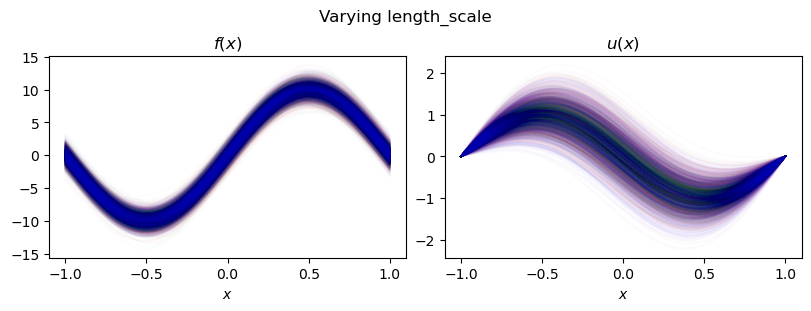

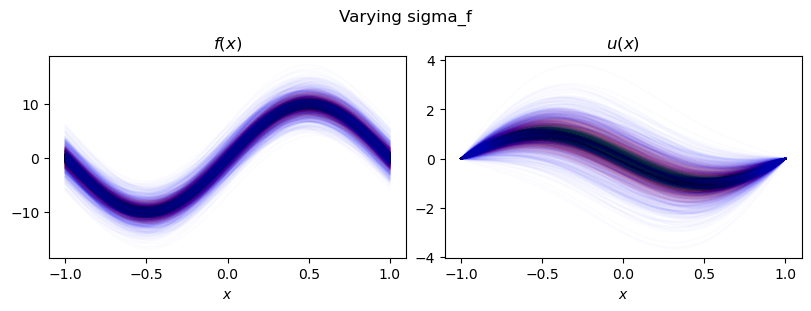

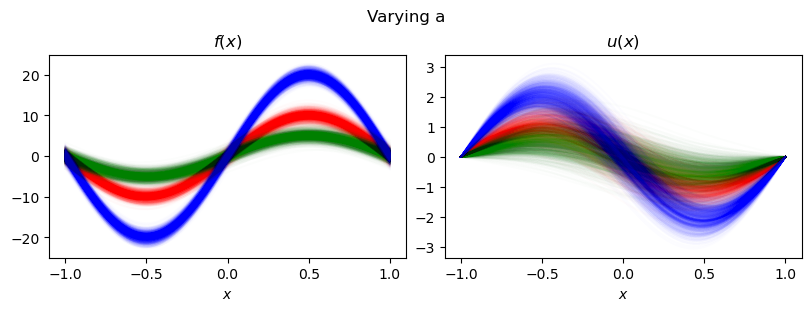

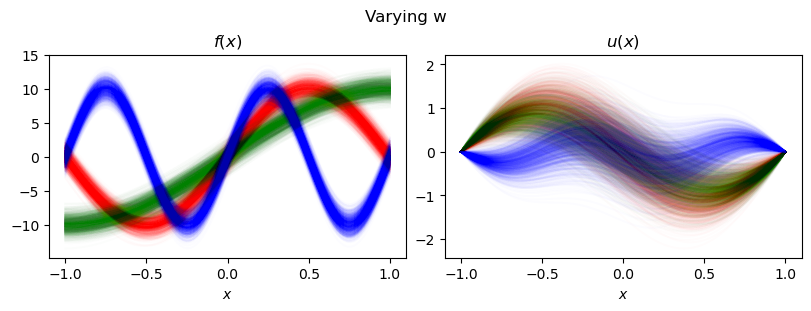

In [11]:
plotted_index_min = 0
plotted_index_max = -1
plotted_colors = ['red', 'green', 'blue']

plotted_indices = (plotted_index_min, plotted_index_max)

for name, name_facts in params_fact.items():
    fig, axs = plt.subplots(1, 2, **fig_kwargs)
    fig.suptitle(f'Varying {name}')

    color_fact = plotted_colors[0]
    axs[0].plot(problem.x, problem_forces.T, color=color_fact, alpha=0.01)
    axs[0].set_xlabel('$x$')
    axs[0].set_title('$f(x)$')
    problem.results.plot(fig_axs=(fig, [axs[1]]), plot_all_kwargs=dict(color=color_fact, alpha=0.01))
    axs[1].set_xlabel('$x$')
    _ = axs[1].set_title('$u(x)$')

    # for i, name_fact in enumerate(name_facts):
    for i in range(len(plotted_indices)):
        name_fact = name_facts[plotted_indices[i]]
        problem_copy = problem.copy()
        setattr(problem_copy, name, getattr(problem, name) * name_fact)
        problem_copy_forces = problem_copy.run()[0]

        color_fact = plotted_colors[i+1]
        axs[0].plot(problem_copy.x, problem_copy_forces.T, color=color_fact, alpha=0.01)
        axs[0].set_xlabel('$x$')
        axs[0].set_title('$f(x)$')
        problem_copy.results.plot(fig_axs=(fig, [axs[1]]), plot_all_kwargs=dict(color=color_fact, alpha=0.01))
        axs[1].set_xlabel('$x$')
        _ = axs[1].set_title('$u(x)$')

In [12]:
vals_precision_tested = {name: name_facts for name, name_facts in params_fact.items()}

md_precision_tested = {name: {} for name in params_fact.keys()}
pvals_precision_tested = {name: {} for name in params_fact.keys()}

for sz in tqdm(tested_sample_sizes, leave=False):
    for name, name_facts in tqdm(params_fact.items(), total=len(params_fact.items()), desc=f'Size {sz}', leave=False):
        err, pval = test_precision_params(
            tested_problems[sz],
            name,
            name_facts,
            (ssr_metadata[sz].ks_stat_mean, ssr_metadata[sz].ks_stat_stdev)
        )
        md_precision_tested[name][sz], pvals_precision_tested[name][sz] = err, pval

  0%|          | 0/5 [00:00<?, ?it/s]

Size 100:   0%|          | 0/4 [00:00<?, ?it/s]

/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i-1] = 1.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i] = -2.0 / dx2
/var/folders/_n/d1yslkkd1337_026z7wnn0cj_nm7v6/T/ipykernel_74517/1038695423.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mat[i, i+1] = 1.0 / dx2


Size 500:   0%|          | 0/4 [00:00<?, ?it/s]

Size 1000:   0%|          | 0/4 [00:00<?, ?it/s]

Size 5000:   0%|          | 0/4 [00:00<?, ?it/s]

Size 10000:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

length_scale:   0%|          | 0/11 [00:00<?, ?it/s]

sigma_f:   0%|          | 0/11 [00:00<?, ?it/s]

a:   0%|          | 0/11 [00:00<?, ?it/s]

w:   0%|          | 0/11 [00:00<?, ?it/s]

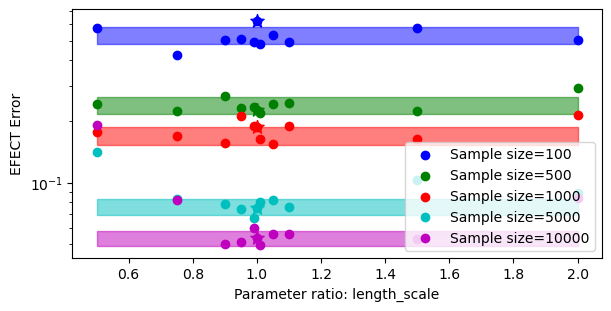

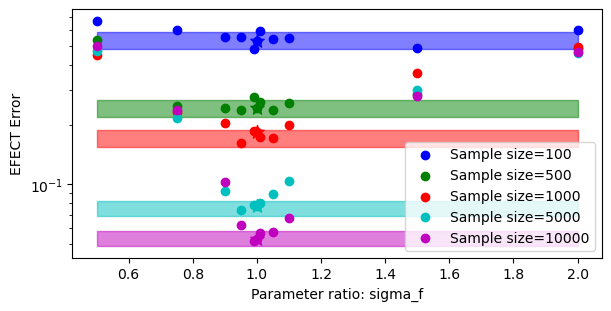

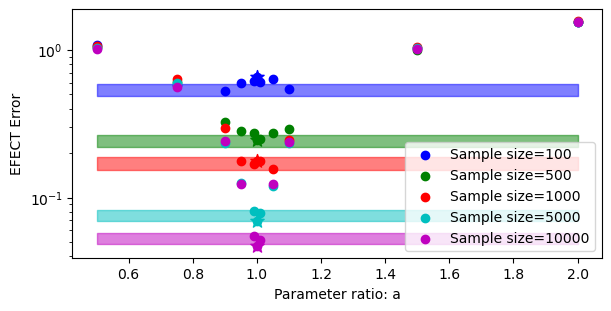

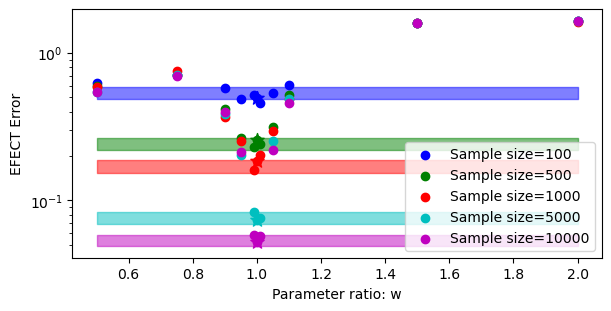

In [13]:
repro_colors = list(mcolors.BASE_COLORS.values())

err_stats = {name: {k: (v.ks_stat_mean, v.ks_stat_stdev) for k, v in ssr_metadata.items()} 
             for name in params_fact.keys()}

for i, name in tqdm(enumerate(md_precision_tested.keys()), total=len(md_precision_tested.keys()), leave=False):
    fig, axs = plt.subplots(1, 1, layout='compressed', figsize=(6.0, 3.0))

    data = md_precision_tested[name]
    name_color = repro_colors[i % len(repro_colors)]
    sde.plot_precision(
        err_stats[name],
        vals_precision_tested[name],
        data,
        fig_axs=(fig, [axs] * len(data.keys())),
        scatter_plot_kwargs={sz: dict(label=f'Sample size={sz}',
                                      color=repro_colors[j % len(repro_colors)]) 
                             for j, sz in enumerate(data.keys())},
        fill_plot_kwargs={sz: dict(color=repro_colors[j % len(repro_colors)]) 
                          for j, sz in enumerate(data.keys())}
    )
    axs.set_xlabel(f'Parameter ratio: {name}')
    axs.set_ylabel(f'EFECT Error')
    axs.legend()

    for i in trange(len(vals_precision_tested[name]), desc=name, leave=False):
        if vals_precision_tested[name][i] == 1.0:
            for j, sz in enumerate(tested_sample_sizes):
                axs.scatter([vals_precision_tested[name][i]], 
                            [md_precision_tested[name][sz][i]], 
                            s=100, 
                            color=repro_colors[j % len(repro_colors)],
                            marker='*')

  0%|          | 0/4 [00:00<?, ?it/s]

length_scale:   0%|          | 0/11 [00:00<?, ?it/s]

sigma_f:   0%|          | 0/11 [00:00<?, ?it/s]

a:   0%|          | 0/11 [00:00<?, ?it/s]

w:   0%|          | 0/11 [00:00<?, ?it/s]

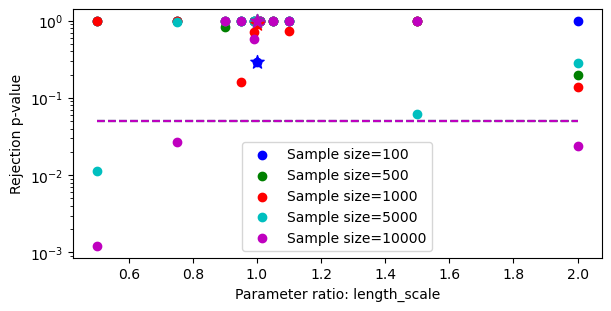

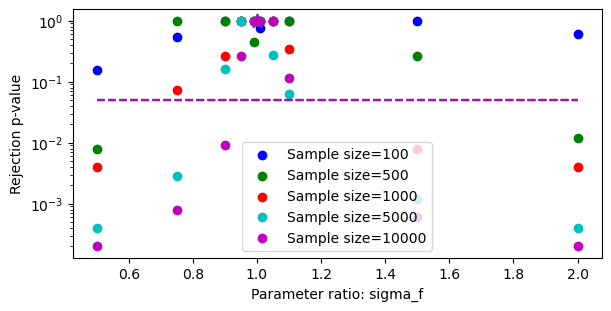

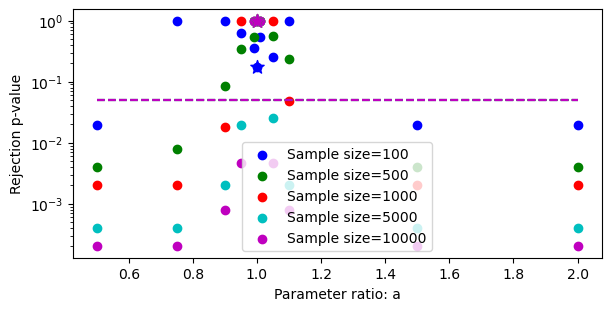

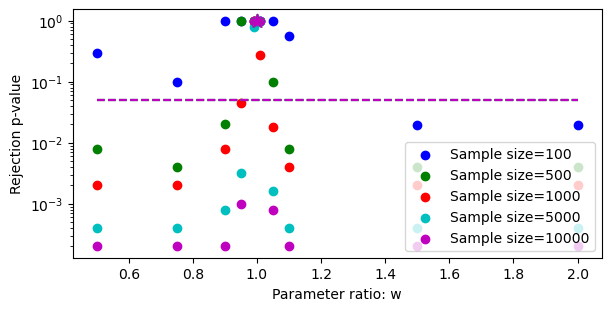

In [14]:
for i, name in tqdm(enumerate(md_precision_tested.keys()), total=len(md_precision_tested.keys()), leave=False):
    data = md_precision_tested[name]

    fig, axs = plt.subplots(1, 1, layout='compressed', figsize=(6.0, 3.0))

    sde.plot_precision_test(
        pvals_precision_tested[name],
        vals_precision_tested[name],
        0.05,
        fig_axs=(fig, [axs] * len(data.keys())),
        plot_kwargs={sz: dict(color=repro_colors[j % len(repro_colors)]) 
                              for j, sz in enumerate(data.keys())},
        scatter_kwargs={sz: dict(label=f'Sample size={sz}', 
                                 color=repro_colors[j % len(repro_colors)]) 
                        for j, sz in enumerate(data.keys())}
    )
    axs.set_xlabel(f'Parameter ratio: {name}')
    axs.set_ylabel(f'Rejection p-value')
    axs.legend()

    for i in trange(len(vals_precision_tested[name]), desc=name, leave=False):
        if vals_precision_tested[name][i] == 1.0:
            for j, sz in enumerate(tested_sample_sizes):
                axs.scatter([vals_precision_tested[name][i]], 
                            [pvals_precision_tested[name][sz][i]], 
                            s=100, 
                            color=repro_colors[j % len(repro_colors)],
                            marker='*')